<a href="https://colab.research.google.com/github/Ruchika-01/AI-projects/blob/main/Credit_Risk_%26_Fraud_Analytics_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Cell 1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/lendingclub_Data_analysis_project/loans_full_schema.csv'
df_raw = pd.read_csv(file_path, low_memory=False)

df_raw.head()
df_raw.shape

Mounted at /content/drive


(10000, 55)

In [ ]:
#Cell 2
df = df_raw.copy()  # working copy

def map_status(x):
    x = str(x).lower()
    if 'charged off' in x or 'default' in x:
        return 1
    if 'late' in x or 'grace' in x:
        return 1
    return 0

df['default_flag'] = df['loan_status'].apply(map_status)
df['default_flag'].value_counts()


,count
default_flag,
0,9822
1,178


In [ ]:
#Cell 3
# Drop rows with missing values only for EDA (safe for small dataset)
df_eda = df.dropna().copy()

df_eda[['loan_purpose', 'homeownership', 'verified_income', 'application_type', 'term']].head()
df_eda['default_flag'].value_counts(normalize=True) * 100


,proportion
default_flag,
0,94.527363
1,5.472637


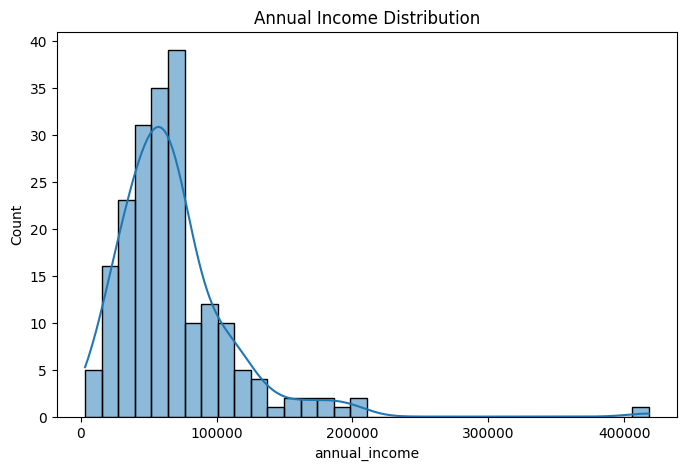

In [ ]:
#Cell 4
plt.figure(figsize=(8,5))
sns.histplot(df_eda['annual_income'], kde=True)
plt.title("Annual Income Distribution")
plt.show()

In [ ]:
#Cell 5
plt.figure(figsize=(8,5))
sns.histplot(df_eda['interest_rate'], kde=True)
plt.title("Interest Rate Distribution")
plt.show()


NameError: name 'plt' is not defined

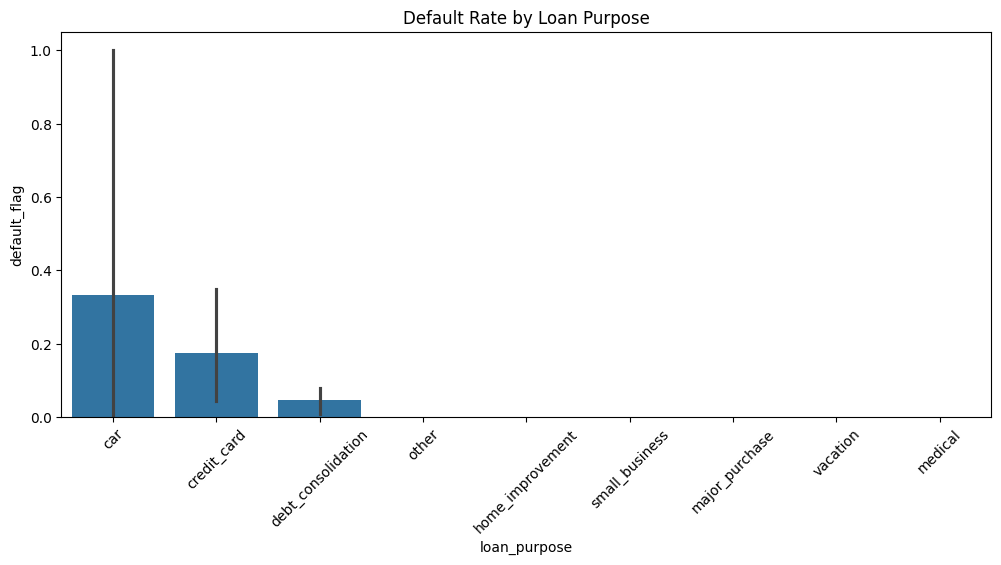

In [ ]:
#Cell 6
plt.figure(figsize=(12,5))
sns.barplot(data=df_eda, x='loan_purpose', y='default_flag')
plt.xticks(rotation=45)
plt.title("Default Rate by Loan Purpose")
plt.show()


In [ ]:
#Cell 7
# Start from df (which has default_flag)
df_model = df.dropna().copy()

selected_cols = [
    # Loan features
    'loan_amount', 'term', 'interest_rate', 'installment',

    # Applicant financial features
    'annual_income', 'verified_income', 'homeownership', 'debt_to_income',

    # Credit history features
    'delinq_2y', 'num_historical_failed_to_pay', 'inquiries_last_12m',
    'total_credit_limit', 'total_credit_utilized',
    'num_open_cc_accounts', 'current_accounts_delinq',
    'public_record_bankrupt',

    # Loan purpose & type
    'loan_purpose', 'application_type',

    # Target
    'default_flag'
]

df_model = df_model[selected_cols].dropna().copy()
df_model.head()
df_model.shape


(201, 19)

In [ ]:
#Cell 8
cat_cols = ['verified_income', 'homeownership', 'loan_purpose', 'application_type', 'term']

# Important: term might be string like '36 months', '60 months'
# If term is numeric already, adjust accordingly.

df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)
df_model.head()
df_model.shape


(201, 27)

In [ ]:
#Cell 9
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['default_flag'])
y = df_model['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((150, 26), (51, 26))

In [ ]:
#Cell 10
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'   # Helps handle imbalance
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [ ]:
#Cell 11
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

AUC: 0.90625

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.00      0.00      0.00         3

    accuracy                           0.94        51
   macro avg       0.47      0.50      0.48        51
weighted avg       0.89      0.94      0.91        51


Confusion Matrix:
 [[48  0]
 [ 3  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Cell 12
# Get predicted probabilities from the trained RandomForest model
y_prob = rf.predict_proba(X_test)[:, 1]

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

thresholds = np.arange(0.05, 0.35, 0.05)

print("AUC:", roc_auc_score(y_test, y_prob))

for t in thresholds:
    print("\n==============================")
    print(f"Threshold: {t}")
    print("==============================")

    y_pred_t = (y_prob >= t).astype(int)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_t))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_t))


AUC: 0.90625

Threshold: 0.05
Confusion Matrix:
[[29 19]
 [ 0  3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        48
           1       0.14      1.00      0.24         3

    accuracy                           0.63        51
   macro avg       0.57      0.80      0.50        51
weighted avg       0.95      0.63      0.72        51


Threshold: 0.1
Confusion Matrix:
[[43  5]
 [ 1  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.93        48
           1       0.29      0.67      0.40         3

    accuracy                           0.88        51
   macro avg       0.63      0.78      0.67        51
weighted avg       0.94      0.88      0.90        51


Threshold: 0.15000000000000002
Confusion Matrix:
[[45  3]
 [ 1  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Cell 13
best_threshold = 0.20

# Final predictions using the selected threshold
y_pred_final = (y_prob >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

print("\nAUC:", roc_auc_score(y_test, y_prob))


NameError: name 'y_prob' is not defined

In [ ]:
#Cell 14
from sklearn.ensemble import IsolationForest

# Select numeric features that indicate suspicious behavior
fraud_features = [
    'annual_income',
    'debt_to_income',
    'total_credit_limit',
    'total_credit_utilized',
    'inquiries_last_12m',
    'delinq_2y',
    'num_historical_failed_to_pay',
    'public_record_bankrupt'
]

X_fraud = df_model[fraud_features]

# Train Isolation Forest
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,    # 5% expected fraud/anomaly
    random_state=42
)

fraud_scores = iso.fit_predict(X_fraud)

# fraud_scores: 1 = normal, -1 = anomaly
df_model['fraud_flag'] = (fraud_scores == -1).astype(int)

df_model[['fraud_flag']].value_counts()


,count
fraud_flag,
0,191
1,10


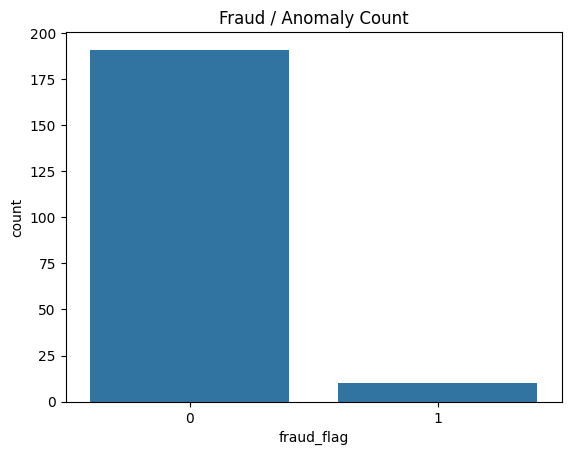

In [ ]:
#Cell 15
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_model['fraud_flag'])
plt.title("Fraud / Anomaly Count")
plt.show()

In [ ]:
#Cell 16
!pip install duckdb

import duckdb
con = duckdb.connect()

In [ ]:
#Cell 17
con.register("loans", df_model)

In [ ]:
#Cell 18
con.execute("""
SELECT
    loan_purpose_credit_card AS is_credit_card,
    loan_purpose_debt_consolidation AS is_debt_consolidation,
    loan_purpose_small_business AS is_small_business,
    AVG(default_flag) AS default_rate
FROM loans
GROUP BY 1,2,3
""").df()


,is_credit_card,is_debt_consolidation,is_small_business,default_rate
0,False,False,False,0.020833
1,True,False,False,0.173913
2,False,True,False,0.047244
3,False,False,True,0.000000


In [ ]:
#Cell 19
con.execute("""
SELECT
    CASE
        WHEN annual_income < 40000 THEN 'Low Income'
        WHEN annual_income BETWEEN 40000 AND 80000 THEN 'Mid Income'
        ELSE 'High Income'
    END AS income_group,
    COUNT(*) AS total_customers,
    SUM(fraud_flag) AS fraud_cases,
    100 * SUM(fraud_flag) / COUNT(*) AS fraud_rate
FROM loans
GROUP BY income_group
ORDER BY fraud_rate DESC;
""").df()


,income_group,total_customers,fraud_cases,fraud_rate
0,High Income,47,5.0,10.638298
1,Low Income,44,2.0,4.545455
2,Mid Income,110,3.0,2.727273


In [ ]:
#Cell 20
con.execute("""
SELECT
    CASE
        WHEN debt_to_income < 15 THEN 'Low Risk'
        WHEN debt_to_income BETWEEN 15 AND 30 THEN 'Medium Risk'
        ELSE 'High Risk'
    END AS dti_risk,
    AVG(default_flag) AS default_rate,
    AVG(fraud_flag) AS fraud_rate
FROM loans
GROUP BY 1
ORDER BY default_rate DESC;
""").df()


,dti_risk,default_rate,fraud_rate
0,Medium Risk,0.108108,0.040541
1,High Risk,0.025000,0.050000
2,Low Risk,0.021277,0.063830


In [ ]:
#Cell 21
con.execute("""
SELECT
    CASE
        WHEN loan_purpose_credit_card = 1 THEN 'Credit Card'
        WHEN loan_purpose_debt_consolidation = 1 THEN 'Debt Consolidation'
        WHEN loan_purpose_home_improvement = 1 THEN 'Home Improvement'
        WHEN loan_purpose_medical = 1 THEN 'Medical'
        WHEN loan_purpose_small_business = 1 THEN 'Small Business'
        WHEN loan_purpose_major_purchase = 1 THEN 'Major Purchase'
        WHEN loan_purpose_vacation = 1 THEN 'Vacation'
        WHEN loan_purpose_other = 1 THEN 'Other'
        ELSE 'Unknown'
    END AS loan_purpose,
    COUNT(*) AS total_loans,
    SUM(default_flag) AS defaults,
    ROUND(100.0 * SUM(default_flag) / COUNT(*), 2) AS default_rate_percent
FROM loans
GROUP BY 1
ORDER BY default_rate_percent DESC;
""").df()


,loan_purpose,total_loans,defaults,default_rate_percent
0,Unknown,3,1.0,33.33
1,Credit Card,23,4.0,17.39
2,Debt Consolidation,127,6.0,4.72
3,Home Improvement,21,0.0,0.00
4,Other,16,0.0,0.00
5,Small Business,3,0.0,0.00
6,Medical,3,0.0,0.00
7,Major Purchase,3,0.0,0.00
8,Vacation,2,0.0,0.00


In [ ]:
#Cell 22
con.execute("""
SELECT
    CASE
        WHEN annual_income < 40000 THEN 'Low Income'
        WHEN annual_income BETWEEN 40000 AND 80000 THEN 'Middle Income'
        ELSE 'High Income'
    END AS income_group,
    COUNT(*) AS borrowers,
    SUM(fraud_flag) AS fraud_cases,
    ROUND(100.0 * SUM(fraud_flag) / COUNT(*), 2) AS fraud_rate_percent
FROM loans
GROUP BY income_group
ORDER BY fraud_rate_percent DESC;
""").df()


,income_group,borrowers,fraud_cases,fraud_rate_percent
0,High Income,47,5.0,10.64
1,Low Income,44,2.0,4.55
2,Middle Income,110,3.0,2.73


In [ ]:
#Cell 23
con.execute("""
SELECT
    CASE
        WHEN debt_to_income < 15 THEN 'Low Risk'
        WHEN debt_to_income BETWEEN 15 AND 30 THEN 'Medium Risk'
        ELSE 'High Risk'
    END AS dti_risk_tier,
    COUNT(*) AS total_customers,
    ROUND(AVG(default_flag), 3) AS default_rate,
    ROUND(AVG(fraud_flag), 3) AS fraud_rate
FROM loans
GROUP BY dti_risk_tier
ORDER BY default_rate DESC;
""").df()


,dti_risk_tier,total_customers,default_rate,fraud_rate
0,Medium Risk,74,0.108,0.041
1,High Risk,80,0.025,0.050
2,Low Risk,47,0.021,0.064


In [ ]:
#Cell 24
con.execute("""
SELECT
    delinq_2y,
    AVG(default_flag) AS default_rate,
    AVG(fraud_flag) AS fraud_rate,
    COUNT(*) AS count
FROM loans
GROUP BY delinq_2y
ORDER BY default_rate DESC;
""").df()


,delinq_2y,default_rate,fraud_rate,count
0,2,0.090909,0.090909,11
1,0,0.070922,0.035461,141
2,1,0.000000,0.075000,40
3,6,0.000000,0.000000,2
4,3,0.000000,0.000000,4
5,7,0.000000,1.000000,1
6,4,0.000000,0.000000,2


In [ ]:
#Cell 25
con.execute("""
SELECT
    CASE
        WHEN total_credit_utilized / NULLIF(total_credit_limit, 0) < 0.30 THEN 'Low Utilization'
        WHEN total_credit_utilized / NULLIF(total_credit_limit, 0) < 0.75 THEN 'Medium Utilization'
        ELSE 'High Utilization'
    END AS utilization_band,
    COUNT(*) AS customers,
    ROUND(AVG(default_flag), 3) AS default_rate,
    ROUND(AVG(fraud_flag), 3) AS fraud_rate
FROM loans
WHERE total_credit_limit > 0
GROUP BY 1
ORDER BY default_rate DESC;
""").df()


,utilization_band,customers,default_rate,fraud_rate
0,High Utilization,25,0.080,0.080
1,Medium Utilization,74,0.068,0.027
2,Low Utilization,102,0.039,0.059


In [ ]:
#Cell 26
!pip install xgboost

In [ ]:
#Cell 27
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
)

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#Cell 28
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


AUC: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       0.00      0.00      0.00         3

    accuracy                           0.94        51
   macro avg       0.47      0.50      0.48        51
weighted avg       0.89      0.94      0.91        51


Confusion Matrix:
 [[48  0]
 [ 3  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Cell 29
import numpy as np

thresholds = np.arange(0.05, 0.35, 0.05)

print("AUC:", roc_auc_score(y_test, y_prob_xgb))

for t in thresholds:
    yp = (y_prob_xgb >= t).astype(int)
    print(f"\n===== Threshold {t} =====")
    print(confusion_matrix(y_test, yp))
    print(classification_report(y_test, yp))


AUC: 0.8333333333333334

===== Threshold 0.05 =====
[[44  4]
 [ 2  1]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        48
           1       0.20      0.33      0.25         3

    accuracy                           0.88        51
   macro avg       0.58      0.62      0.59        51
weighted avg       0.91      0.88      0.90        51


===== Threshold 0.1 =====
[[46  2]
 [ 2  1]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.33      0.33      0.33         3

    accuracy                           0.92        51
   macro avg       0.65      0.65      0.65        51
weighted avg       0.92      0.92      0.92        51


===== Threshold 0.15000000000000002 =====
[[47  1]
 [ 2  1]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        48
           1       0.50      0.33      0.40         3

   

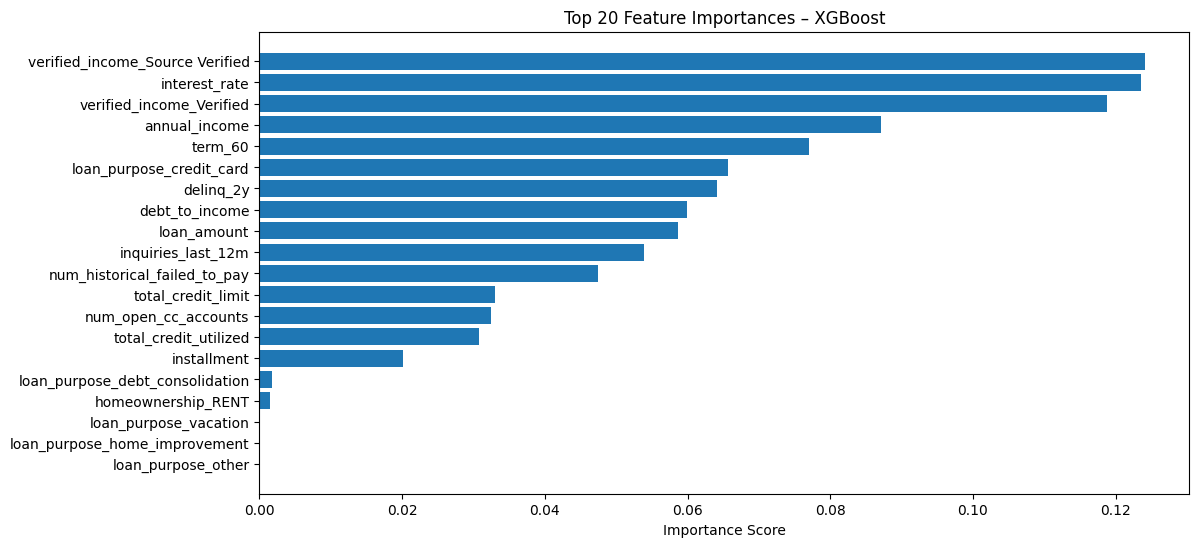

In [ ]:
#Cell 30
import matplotlib.pyplot as plt
import numpy as np

importance_vals = xgb_model.feature_importances_
sorted_idx = np.argsort(importance_vals)[::-1]

plt.figure(figsize=(12,6))
plt.barh(np.array(X.columns)[sorted_idx][:20], importance_vals[sorted_idx][:20])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances – XGBoost")
plt.xlabel("Importance Score")
plt.show()


In [ ]:
#Cell 31
import pandas as pd

# Make a small A/B-testing dataframe
ab_df = df_model[['default_flag', 'term_60']].copy()

# Label the groups for readability
ab_df['offer_group'] = ab_df['term_60'].apply(lambda x: 'B_60_month' if x == 1 else 'A_36_month')

ab_df['offer_group'].value_counts()

,count
offer_group,
A_36_month,113
B_60_month,88


In [ ]:
#Cell 32
group_stats = (
    ab_df
    .groupby('offer_group')['default_flag']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'n_loans', 'sum': 'n_defaults', 'mean': 'default_rate'})
)

group_stats


,n_loans,n_defaults,default_rate
offer_group,,,
A_36_month,113,7,0.061947
B_60_month,88,4,0.045455


In [ ]:
#Cell 33
from statsmodels.stats.proportion import proportions_ztest

# Extract counts from group_stats
defaults_A = group_stats.loc['A_36_month', 'n_defaults']
loans_A    = group_stats.loc['A_36_month', 'n_loans']

defaults_B = group_stats.loc['B_60_month', 'n_defaults']
loans_B    = group_stats.loc['B_60_month', 'n_loans']

counts = [defaults_A, defaults_B]
nobs   = [loans_A, loans_B]

z_stat, p_val = proportions_ztest(count=counts, nobs=nobs)

print("Z-statistic:", z_stat)
print("P-value:", p_val)
group_stats


Z-statistic: 0.5100211379198665
P-value: 0.6100366529915431


,n_loans,n_defaults,default_rate
offer_group,,,
A_36_month,113,7,0.061947
B_60_month,88,4,0.045455


In [ ]:
#Cell 34
summary = group_stats.copy()
summary['default_rate_percent'] = (summary['default_rate'] * 100).round(2)
summary

,n_loans,n_defaults,default_rate,default_rate_percent
offer_group,,,,
A_36_month,113,7,0.061947,6.19
B_60_month,88,4,0.045455,4.55


/tmp/ipython-input-1994921727.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_model.groupby('dti_tier')


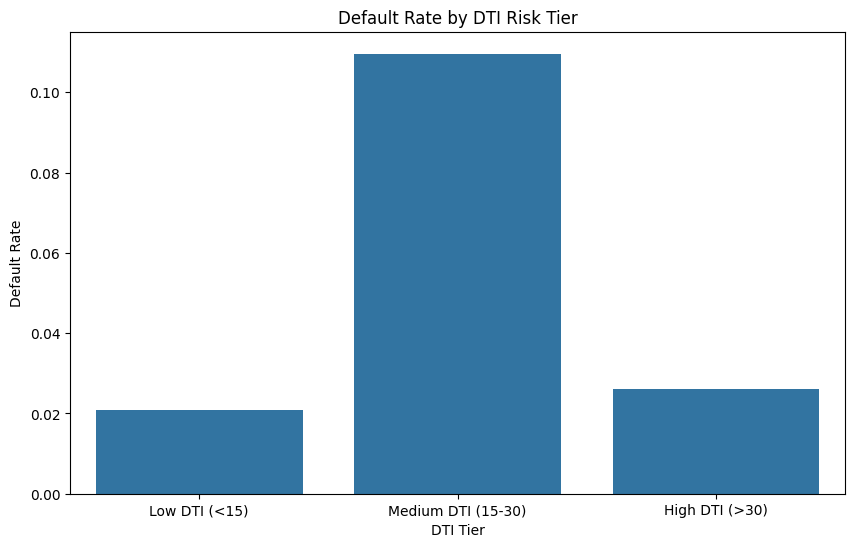

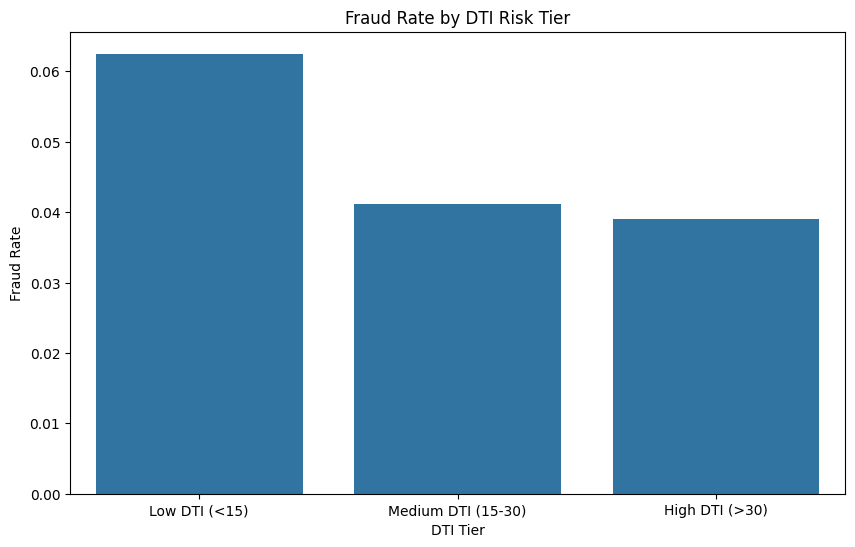

In [ ]:
#Cell 35
import seaborn as sns
import matplotlib.pyplot as plt

# Create DTI risk tiers
df_model['dti_tier'] = pd.cut(
    df_model['debt_to_income'],
    bins=[-1, 15, 30, 100],
    labels=['Low DTI (<15)', 'Medium DTI (15-30)', 'High DTI (>30)']
)

risk_tier_df = (
    df_model.groupby('dti_tier')
            .agg(default_rate=('default_flag','mean'),
                 fraud_rate=('fraud_flag','mean'),
                 count=('default_flag','count'))
            .reset_index()
)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=risk_tier_df, x='dti_tier', y='default_rate')
plt.title('Default Rate by DTI Risk Tier')
plt.ylabel('Default Rate')
plt.xlabel('DTI Tier')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=risk_tier_df, x='dti_tier', y='fraud_rate')
plt.title('Fraud Rate by DTI Risk Tier')
plt.ylabel('Fraud Rate')
plt.xlabel('DTI Tier')
plt.show()


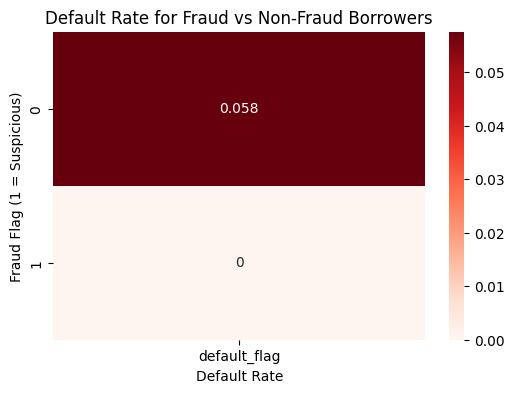

In [ ]:
#Cell 36
pivot = df_model.pivot_table(
    index='fraud_flag',
    values='default_flag',
    aggfunc='mean'
).reset_index()

plt.figure(figsize=(6,4))
sns.heatmap(pivot.set_index('fraud_flag'), annot=True, cmap='Reds')
plt.title("Default Rate for Fraud vs Non-Fraud Borrowers")
plt.ylabel("Fraud Flag (1 = Suspicious)")
plt.xlabel("Default Rate")
plt.show()


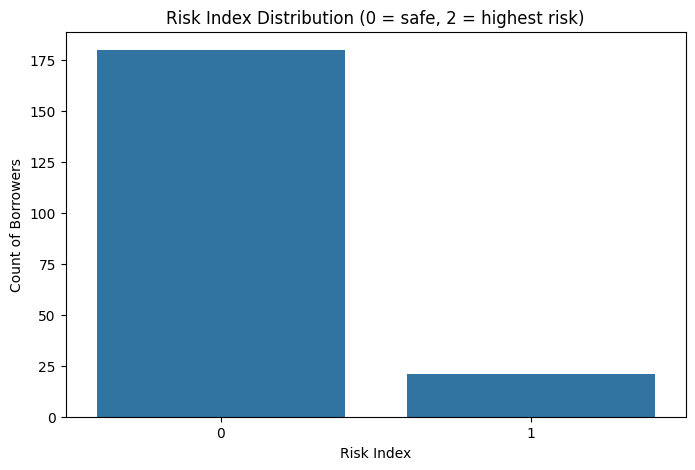

In [ ]:
#Cell 37
df_model['risk_index'] = df_model['default_flag'] + df_model['fraud_flag']

plt.figure(figsize=(8,5))
sns.countplot(x=df_model['risk_index'])
plt.title("Risk Index Distribution (0 = safe, 2 = highest risk)")
plt.xlabel("Risk Index")
plt.ylabel("Count of Borrowers")
plt.show()
